Bibliografía: 
- U.S. Army Corps of Engineers (1992) - EM 1110-1-1905
- Baban (2016) - Shallow Foundations

**Terzaghi**: mejor para suelos muy cohesivos donde D/B ≤ 1 o para una estimación rápida de qult para comparar con otros métodos. No utilizar para zapatas con momentos y/o fuerzas horizontales ni para bases inclinadas y/o terrenos inclinados. 

**Hansen, Meyerhof, Vesic**: aplica a cualquier situación.

**Hansen, Vesic**: mejor cuando la base está inclinada, cuando la zapata está en pendiente o cuando D/B > 1.

- Asentamientos totales: valor típico aceptable: 1 pulgada.
- Asentamientos diferenciales: valor típico aceptable: 1/500.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from scipy import sqrt
import numpy as np
import pandas as pd
from IPython.display import display, Latex


## Carga de datos 

In [2]:
#Datos

D=2                #Tapada, en [m]
sigma_v=20         #Presion efectiva en el plano de fundación, en [kPa] 
su=40              #Resistencia al corte no drenado,en [kPa]
gamma=19           #Peso unitario efectivo bajo el plano de fundación (zona de falla), [kN/m3]
gamma_D=19         #Peso unitario efectivo del suelo desde la superficie hasta el plano de fundacion, [kN/m3]
phi=30              #Angulo de fricción interna, [deg] (si es no drenado poner phi=0)
c=15               #Cohesion, [kPa]
V=0                #Carga normal, en [kN]


#Lado B

B=2                #Ancho de la base, en [m]
e_B=0.1            #Excentricidad de aplicación de la carga, en [m]
H_B=5              #Fuerza horizontal, [kN]
beta_B=5           #Inclinación del terreno,[deg]
omega_B=5          #Inclinación de la base,[deg]


#Lado L

L=4                #Longitud de la base, en [m]
e_L=0              #Excentricidad de aplicación de la carga, en [m]
H_L=0              #Fuerza horizontal, [kN]
beta_L=5           #Inclinación del terreno,[deg]
omega_L=5          #Inclinación de la base,[deg]

In [3]:
c_local=2/3*c
phi_local=np.arctan(2/3*np.tan(np.radians(phi)))
print(c_local)
print(np.degrees(phi_local))

10.0
21.05172443537292


## Cálculos

Los factores $N_{c}$, $N_{q}$ y $N_{\gamma}$ adimensionales son función del ángulo de friccion interna, $\phi'$

**Modelo de Hansen**: considera bases inclinadas y pendientes, además de la forma y excentricidad de los cimientos, la inclinación de la carga y la profundidad de los cimientos. 
Los supuestos se basan en una ampliación del trabajo de Meyerhof para incluir la inclinación
de la base y la construcción en pendiente. Puede utilizarse cualquier relación D/B.

**Restricciones**: Forma de cimentación con excentricidad $s_{c}$, $s_{\gamma}$, y $s_{q}$ y factores de corrección de carga inclinada $i_{c}$, $i_{\gamma}$, y $i_{q}$ no podrán utilizarse simultáneamente. Los factores de corrección no utilizados son la unidad.

In [4]:
#Expresiones segun Hansen 1970


Nfi=np.tan(np.radians(45+phi/2))**2

if phi==0:
    Nc=np.pi+2
    Nq=1
    Ngamma=0 
else:
    Nq=np.exp(np.pi*np.tan(np.radians(phi)))*(np.tan(np.pi/4+np.radians(phi)/2))**2
    Nc=(Nq-1)*1/(np.tan(np.radians(phi)))
    Ngamma=1.5*(Nq-1)*np.tan(np.radians(phi))  

       
B_eq= B-2*e_B                                      #Ancho equivalente, en [m]
L_eq= L-2*e_L                                      #Longitud equivalente, en [m]

Los factores de corrección $\zeta$ adimensionales consideran una variedad de opciones para modelar las condiciones reales del suelo y la fundación. Dependen de del modelo seleccionado para la solución de la capacidad portante última. Consideran: forma de cimentación con excentricidad, carga inclinada, profundidad de cimentación y base de cimentación inclinada.

In [5]:
#Correcciones segun Hansen

#Corrección por inclinación de la carga ("i")

if H_B>0:
    a_B=(1-(0.5*H_B/(V+B_eq*L_eq*c/np.tan(np.radians(phi))))if phi != 0 else 1)**5
    b_B=(1-(0.7*H_B/(V+B_eq*L_eq*c/np.tan(np.radians(phi))))if phi != 0 else 1)**5
else:
    a_B=1
    b_B=1
    
if H_L>0:
    a_L=(1-(0.5*H_L/(V+B_eq*L_eq*c/np.tan(np.radians(phi))))if phi != 0 else 1)**5
    b_L=(1-(0.7*H_L/(V+B_eq*L_eq*c/np.tan(np.radians(phi))))if phi != 0 else 1)**5
else:
    a_L=1
    b_L=1

iq_B=max(0,a_B)
igamma_B=max(0,b_B)

iq_L=max(0,a_L)
igamma_L=max(0,b_L)

if phi==0:
    ic_B=0.5-0.5*((1-H_B/(B_eq*L_eq*su))**0.5)
    ic_L=0.5-0.5*((1-H_L/(B_eq*L_eq*su))**0.5)       
else:
    ic_B=max(0,(iq_B-(1-iq_B)/(Nq-1)))
    ic_L=max(0,(iq_L-(1-iq_L)/(Nq-1)))


#Corrección por forma ("s")

sq_B=max(0,(1+np.sin(np.radians(phi))*B_eq/L_eq*iq_B))
sgamma_B=max(0.6,(1-(0.4*B_eq/L_eq*igamma_B/igamma_L)))

sq_L=max(0,(1+np.sin(np.radians(phi))*B_eq/L_eq*iq_L))
sgamma_L=max(0.6,(1-(0.4*L_eq/B_eq*igamma_L/igamma_B)))

if phi==0:
    sc_B=0.2*B_eq/L_eq   
    sc_L=0.2*L_eq/B_eq 
else:
    sc_B=max(0,(1+Nq/Nc*B_eq/L_eq))
    sc_L=max(0,(1+Nq/Nc*L_eq/B_eq))

#Corrección por profundidad ("d")

if D/B<=1:
    k_B=D/B #coeficiente en radianes
else:
    k_B=np.arctan(D/B)
    
if D/L<=1:
    k_L=D/L #coeficiente en radianes
else:
    k_L=np.arctan(D/L)


dq_B=max(0,1+2*np.tan(np.radians(phi))*k_B*(1-np.sin(np.radians(phi)))**2)
dgamma_B=1

dq_L=max(0,1+2*np.tan(np.radians(phi))*k_L*(1-np.sin(np.radians(phi)))**2)
dgamma_L=1

if phi==0:
    dc_B=0.4*k_B
    dc_L=0.4*k_L 
else:
    dc_B=max(0,1+0.4*k_B)
    dc_L=max(0,1+0.4*k_L)


#Corrección por inclinación de la base ("b")

bq_B=max(0,np.exp(-1*max(0,np.radians(omega_B))*np.tan(np.radians(phi))))
bgamma_B=max(0,np.exp(-2.7*max(0,np.radians(omega_B))*np.tan(np.radians(phi))))

bq_L=max(0,np.exp(-1*max(0,np.radians(omega_L))*np.tan(np.radians(phi))))
bgamma_L=max(0,np.exp(-2.7*max(0,np.radians(omega_L))*np.tan(np.radians(phi))))

if phi==0:
    bc_B=(max(0,omega_B)/147)
    bc_L=(max(0,omega_L)/147)
    
else:
    bc_B=1-max(0,omega_B)/147
    bc_L=1-max(0,omega_L)/147


#Corrección por inclinación del terreno ("g")

gq_B = max(0, (1-(0.5 * (np.tan(np.radians(beta_B)))))**5)

ggamma_B=gq_B

gq_L = max(0, (1-(0.5 * (np.tan(np.radians(beta_L)))))**5)

ggamma_L=gq_L
    
if phi==0:
    gc_B=(max(0,beta_B)/147)
    gc_L=(max(0,beta_L)/147)
    
else:
    gc_B=1-max(0,beta_B)/147
    gc_L=1-max(0,beta_L)/147


In [6]:
#Capacidad de carga - BH 

if phi==0:
    qu_B=(Nc*su*(1+sc_B+dc_B-ic_B-bc_B-gc_B)+sigma_v)*((B_eq*L_eq)/(B*L))
    qu_L=(Nc*su*(1+sc_L+dc_L-ic_L-bc_L-gc_L)+sigma_v)*((B_eq*L_eq)/(B*L))
else:
    qu_B=(c*Nc*ic_B*sc_B*dc_B*bc_B*gc_B+sigma_v*Nq*iq_B*sq_B*dq_B*bq_B*gq_B+0.5*gamma*B_eq*Ngamma*igamma_B*sgamma_B*dgamma_B*bgamma_B*ggamma_B)*(B_eq*L_eq)/(B*L)
    qu_L=(c*Nc*ic_L*sc_L*dc_L*bc_L*gc_L+sigma_v*Nq*iq_L*sq_L*dq_L*bq_L*gq_L+0.5*gamma*L_eq*Ngamma*igamma_L*sgamma_L*dgamma_L*bgamma_L*ggamma_L)*(B_eq*L_eq)/(B*L)

qu_BH=min(qu_B,qu_L)

print(np.round(qu_B,1))
print(np.round(qu_L,1))
print(np.round(qu_BH,1))

q_neta=qu_BH-gamma_D*D

1121.4
1642.6
1121.4


## Resumen de resultados

In [7]:
def redondear_valor(valor, n):
    return round(valor, n)

if phi==0:
    datos = {"Datos de entrada": ["$D$", "$\sigma'_v$","$s_{u}$","$V$","$B$","$L$","$e_{B}$","$e_{L}$","$H_{B}$","$H_{L}$","$\beta_ B$","$\beta_ L$","$\omega_{B}$","$\omega_{L}$"],
          "Unidades":["$m$", "$kPa$","$kPa$", "$kN$","$m$","$m$","$m$","$m$","$kN$","$kN$","$deg$","$deg$","$deg$","$deg$"],
            "Valor":[D, sigma_v, su, V,B,L,e_B,e_L,H_B,H_L,beta_B,beta_L,omega_B,omega_L]}
else:
    datos = {"Datos de entrada": ["$D$", "$\sigma'_v$", "$\gamma'$", "$\gamma'_{D}$", "$\phi$", "$c$", "$V$","$B$","$L$","$e_{B}$","$e_{L}$","$H_{B}$","$H_{L}$","$\beta_B$","$\beta_L$","$\omega_{B}$","$\omega_{L}$"],
          "Unidades":["$m$", "$kPa$", "$kN/m3$", "$kN/m3$", "$deg$", "$kPa$", "$kN$","$m$","$m$","$m$","$m$","$kN$","$kN$","$deg$","$deg$","$deg$","$deg$"],
            "Valor":[D, sigma_v, gamma, gamma_D, phi, c, V,B,L,e_B,e_L,H_B,H_L,beta_B,beta_L,omega_B,omega_L]}

datos["Valor"] = [redondear_valor(float(valor), 2) for valor in datos["Valor"]]

tabla_datos = pd.DataFrame(datos)
#---------------------------------------------------------------------------------

N_values = N_values = {"Factores": ["$N_{c}$", "$N_{q}$", "$N_{\gamma}$"],
          "Valor": [Nc, Nq, Ngamma]}
N_values["Valor"] = [redondear_valor(float(valor), 2) for valor in N_values["Valor"]]
tabla_N = pd.DataFrame(N_values)


#---------------------------------------------------------------------------------
if phi==0:
    data_B = {"Lado B": ["$B_{eq}$", "$L_{eq}$", "$i_c$", "$s_c$", "$d_c$", "$b_c$", "$g_c$"],
          "Valor": [B_eq, L_eq, ic_B, sc_B, dc_B, bc_B, gc_B]}
else:
    data_B = {"Lado B": ["$B_{eq}$", "$L_{eq}$", "$i_c$", "$i_q$","$i_\gamma$","$s_c$","$s_q$","$s_\gamma$", "$d_c$","$d_q$","$d_\gamma$","$b_c$","$b_q$","$b_\gamma$", "$g_c$","$g_q$","$g_\gamma$"],
          "Valor": [B_eq, L_eq, ic_B, iq_B, igamma_B, sc_B, sq_B, sgamma_B,dc_B, dq_B, dgamma_B, bc_B, bq_B, bgamma_B,gc_B, gq_B, ggamma_B]}
if phi==0:
    data_L = {"Lado L": ["$B_{eq}$", "$L_{eq}$", "$i_c$", "$s_c$", "$d_c$", "$b_c$", "$g_c$"],
          "Valor": [B_eq, L_eq, ic_L, sc_L, dc_L, bc_L, gc_L]}
else:
    data_L = {"Lado L": ["$B_{eq}$", "$L_{eq}$", "$i_c$", "$i_q$","$i_\gamma$","$s_c$","$s_q$","$s_\gamma$", "$d_c$","$d_q$","$d_\gamma$","$b_c$","$b_q$","$b_\gamma$", "$g_c$","$g_q$","$g_\gamma$"],
          "Valor": [B_eq, L_eq, ic_L, iq_L, igamma_L, sc_L, sq_L, sgamma_L,dc_L, dq_L, dgamma_L, bc_L, bq_L, bgamma_L,gc_L, gq_L, ggamma_L]}


data_B["Valor"] = [redondear_valor(float(valor), 2) for valor in data_B["Valor"]]
data_L["Valor"] = [redondear_valor(float(valor), 2) for valor in data_L["Valor"]]

tabla_B = pd.DataFrame(data_B)
tabla_L = pd.DataFrame(data_L)

# Concatenar las tablas horizontalmente
tabla_concatenada = pd.concat([tabla_B, tabla_L], axis=1)

#---------------------------------------------------------------------------------

qu_values = qu_values = {"$q_{u,BH} [kN/m2]$": ["$q_{u,B}$", "$q_{u,L}$", "$q_{u}$"],
          "Valor": [qu_B, qu_L, qu_BH]}


qu_values["Valor"] = [redondear_valor(float(valor), 2) for valor in qu_values["Valor"]]

tabla_q = pd.DataFrame(qu_values)


In [8]:
tabla_datos

,Datos de entrada,Unidades,Valor
0,$D$,$m$,2.0
1,$\sigma'_v$,$kPa$,20.0
2,$\gamma'$,$kN/m3$,19.0
3,$\gamma'_{D}$,$kN/m3$,19.0
4,$\phi$,$deg$,30.0
5,$c$,$kPa$,15.0
6,$V$,$kN$,0.0
7,$B$,$m$,2.0
8,$L$,$m$,4.0
9,$e_{B}$,$m$,0.1


In [9]:
tabla_N

,Factores,Valor
0,$N_{c}$,30.14
1,$N_{q}$,18.40
2,$N_{\gamma}$,15.07


In [10]:
tabla_concatenada

,Lado B,Valor,Lado L,Valor
0,$B_{eq}$,1.80,$B_{eq}$,1.80
1,$L_{eq}$,4.00,$L_{eq}$,4.00
2,$i_c$,0.93,$i_c$,1.00
3,$i_q$,0.93,$i_q$,1.00
4,$i_\gamma$,0.91,$i_\gamma$,1.00
5,$s_c$,1.27,$s_c$,2.36
6,$s_q$,1.21,$s_q$,1.23
7,$s_\gamma$,0.84,$s_\gamma$,0.60
8,$d_c$,1.40,$d_c$,1.20
9,$d_q$,1.29,$d_q$,1.14


In [11]:
tabla_q

,"$q_{u,BH} [kN/m2]$",Valor
0,"$q_{u,B}$",1121.36
1,"$q_{u,L}$",1642.58
2,$q_{u}$,1121.36


Otras correcciones
(chequear)

In [12]:
 #Correccion por fundaciones largas

r_gammaB=1-0.25*np.log(B/2) if B>2 else 1      
r_gammaB
r_gammaL=1-0.25*np.log(L/2) if L>2 else 1
r_gammaL

0.8267132048600137

In [13]:
#Influencia del nivel freatico
#Respecto al termino N_gamma

gamma_wet=18
gamma_sat=19
gamma_w=10
gamma_ef=gamma_sat-gamma_w
NF=10 #Profundidad del nivel freatico, en metros

zw=NF-D #Distancia entre el nivel de fundacion y el nivel de agua

H=min(B,0.5*B*np.tan(np.radians(45+phi/2)))

if zw<=0:
    gamma=gamma_ef

elif 0<zw<=B:
    gamma=(2*H-zw)*zw/(H**2)*gamma_wet+gamma_ef/(H**2)*(H-zw)**2

elif zw>B:
    gamma=gamma_wet


In [14]:
#Influencia en el termino Nq
if NF<D:
    gamma=gamma_ef
    q=gamma_ef*D
    
elif 0<NF<D:
    q=gamma_wet*NF+gamma_ef*(D-NF)

elif NF>D:
    gamma=gamma_wet
    q=gamma_wet*D
       


In [15]:
#Influencia de la compresibilidad del suelo en la capacidad de carga
#Efecto de cimentaciones adyacentes en la capacidad de carga
#Capacidad de carga para fundaciones en taludes
#Capacidad de carga en fundaciones sobre terreno estratificado
#Capacidad de carga con mediciones in situ

In [16]:
#Capacidad de carga - BH 

if phi==0:
    qu_B=(Nc*su*(1+sc_B+dc_B-ic_B-bc_B-gc_B)+sigma_v)*((B_eq*L_eq)/(B*L))
    qu_L=(Nc*su*(1+sc_L+dc_L-ic_L-bc_L-gc_L)+sigma_v)*((B_eq*L_eq)/(B*L))
else:
    qu_B=(c*Nc*ic_B*sc_B*dc_B*bc_B*gc_B+sigma_v*Nq*iq_B*sq_B*dq_B*bq_B*gq_B+0.5*gamma*B_eq*Ngamma*r_gammaB*igamma_B*sgamma_B*dgamma_B*bgamma_B*ggamma_B)*(B_eq*L_eq)/(B*L)
    qu_L=(c*Nc*ic_L*sc_L*dc_L*bc_L*gc_L+sigma_v*Nq*iq_L*sq_L*dq_L*bq_L*gq_L+0.5*gamma*L_eq*Ngamma*r_gammaL*igamma_L*sgamma_L*dgamma_L*bgamma_L*ggamma_L)*(B_eq*L_eq)/(B*L)

qu_BH=min(qu_B,qu_L)

print(np.round(qu_B,1))
print(np.round(qu_L,1))
print(np.round(qu_BH,1))

q_neta=qu_BH-gamma_D*D

1114.9
1595.8
1114.9


Skempton (1951) concluyó que el factor de capacidad portante Nc para arcillas saturadas en condiciones no drenadas Ø=0 es función de la forma de la zapata y de la relación profundidad/anchura.
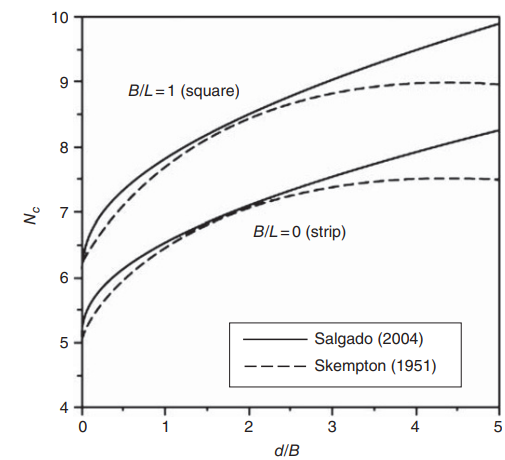
En la práctica, Nc se limita normalmente a un valor igual a 9,0 para cimentaciones cuadradas o circulares muy profundamente empotradas.

In [17]:
if phi==0 and B==L:                                                                         #zapatas cuadradas o circulares
    Nc=((2+np.pi)*(1+0.27)*(D/B)**0.5)

elif phi==0 and B!=L:
    Nc=((2+np.pi)*(1+0.27)*(D/min(B,L)**0.5)*(0.84+0.16*min(B,L)/max(B,L)))                 #zapatas rectangulares

else:
    Nc=(Nq-1)*1/(np.tan(np.radians(phi)))
    